In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep
import scipy


import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from sklearn.manifold import MDS


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.data.make_dataset import make_swiss
from src.fim_noemb import FIM
import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
from sklearn.manifold import Isomap
from sklearn import datasets

#from mpl_tookits import mplot3d


In [2]:
print(pl.__version__)
print(torch.__version__)

1.8.0
2.0.1+cu117


# Define JSD Function

In [16]:


def computeJSD(X):
    
    #NOTE: Input for this function is matrix where the rows are log-transformed probabilites

    jsd = torch.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):

        p = X[i,:]
        q = X
        m = (0.5 * (p.exp() + q.exp()))
        

        kone = 0.5 *( (p.exp() * (p - m.log() ) ).sum(dim=1))
        ktwo = 0.5 *( (q.exp() * (q - m.log() ) ).sum(dim=1))
        k = kone + ktwo

        jsd[i,:] = k
     
    jsd.fill_diagonal_(0) #setting diagonal to 0 to avoid nan's
            
    return jsd.to('cuda')
    
def discard_out(metric,n_obs,per):
    
    ns_obs = per*n_obs
    out = int((n_obs - ns_obs)/2)
    sor = np.argsort(metric)
    lwindx = out
    upindx = n_obs - out
    sortind = sor[lwindx:upindx]
    return sortind
    

# Parameter definition

In [9]:
# Data Parameters
dataset = "tree"
n_obs = 1500
n_dim = 10
batch_size = 150

# Model param
encoder_layer = [100,100,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 20  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 5 # PHATE kernel number of Nearest Neighbors.
logp=False #Rescale of PHATE parameters

# Trainer param
max_epochs = 150
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "tree_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))

In [5]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="tree_autoenocder_logp", name=exp_name) if wandb else False

In [6]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)


/gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFIMvtwo/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


# Define pytorch model

In [10]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
# train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model, train_dataloaders=train_loader)

/gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFIMvtwo/lib/python3.11/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
[rank: 0] Global seed set to 768
/gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFIMvtwo/lib/python3.11/site-packages/lightning_lite/plugins/environments/slurm.py:169: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFI ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/project/gilbert/of56/conda_en

[Linear(in_features=10, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=100, bias=True), ReLU(), Linear(in_features=100, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]
/bin/srun
/bin/srun


/gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFIMvtwo/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


In [13]:
#save model (and load model)

#torch.save(model.state_dict(),'saved_models/tree_model_5_22.pt')
#model.load_state_dict(torch.load('saved_models/tree_model_1_25_JSD.pt'))



# Randomly sample new data points from tree distribution and encode with NeuralFIM

In [13]:

inference_obs = 1600
tree_data, tree_phate, tree_clusters = make_tree(n_obs=inference_obs, dim=10,emb_dim=2,knn=knn)
model.cuda()
model.eval()
tree_data.cuda()
tree_data = tree_data.to('cuda')
pred = model.encode(tree_data).detach().cpu().numpy()


# Compute FIM, FIM Volume, FIM Trace

In [14]:

#Define model/function
model.cuda()
fcn = model.encode


#FIM
fisher = FIM(tree_data,fcn,inference_obs,n_dim,emb_dim,pred)
fishermat, J = fisher.fit()

#FIM spectra
e,v = fisher.get_eigs()

#FIM volume
volume = fisher.get_volume()

#FIM trace
trace = np.zeros((n_obs))
for i in range(n_obs):
    trace[i] = np.sum(e[i,:])

print("Number of observations:",inference_obs)
print("Ambient dimension:",n_dim)
print("Embedding dimension:",emb_dim)


Number of observations 1600
Ambient dimension 10
Embedding dimension 50


# Visualization of PHATE-JSD embedding with FIM metrics

/gpfs/gibbs/project/gilbert/of56/conda_envs/NeuralFIMvtwo/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


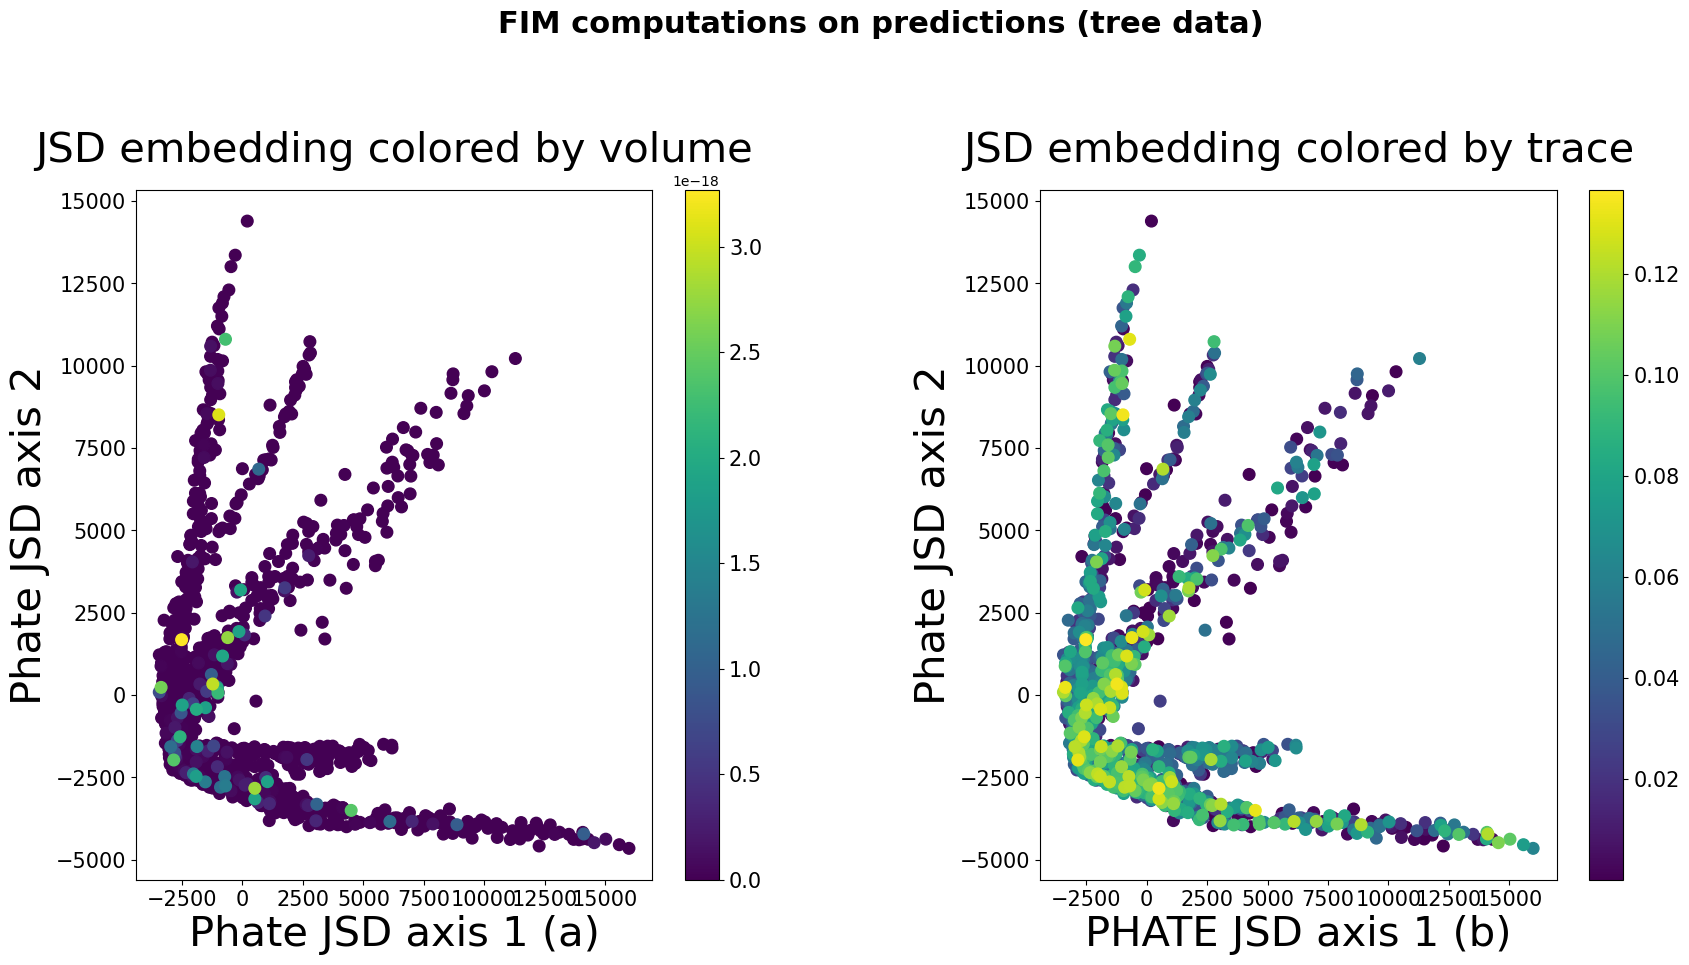

In [19]:

#Pads axis titles
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

#Compute middle x% of volume and trace outliers
CI = 0.95 
vind = discard_out(volume,n_obs,CI)
nvolume = volume[vind]

tind = discard_out(trace,n_obs,CI)
ntrace = trace[tind]


#Compute PHATE with JSD-step for visualization
phate_op = phate.PHATE(random_state=42, verbose=False, knn=5).fit(tree_data.cpu().detach().numpy())
diff_pot =torch.tensor(phate_op.diff_potential).float()
gtdist = torch.sqrt( torch.abs(computeJSD(diff_pot)) )
mds_operator = MDS(dissimilarity='precomputed')
phateJSDemb_tree= mds_operator.fit_transform(gtdist.detach().cpu().numpy())


fig = plt.figure(figsize=(20,10))
plt.suptitle("FIM computations on predictions (tree data) ",fontsize=22,fontweight='bold')
plt.subplots_adjust(hspace=1.0,wspace=0.4,top=0.8)



#Volume
plt.subplot(121)
plt.title("JSD embedding colored by volume",fontsize=30)
#plt.scatter(predemb[vind, 0], predemb[vind, 1], c= nvolume)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= nvolume,s=70)
plt.xlabel("Phate JSD axis 1 (a)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15) 



#Trace
plt.subplot(122)
plt.title("JSD embedding colored by trace",fontsize=30)
#plt.scatter(predemb[tind, 0], predemb[tind, 1], c= ntrace)
plt.scatter(phateJSDemb_tree[tind, 0], phateJSDemb_tree[tind, 1], c= ntrace,s=70)
plt.xlabel("PHATE JSD axis 1 (b)",fontsize=30)
plt.ylabel("Phate JSD axis 2",fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15) 



